# The value of dependencies for Ethereum dapps

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from scripts.oso_db import execute_query
from visualizations.sankey import make_sankey_graph

In [24]:
GRAY = '#CCC'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'sans-serif']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelcolor'] = GRAY

In [2]:
deps_list = ['wagmi-dev', 'web3', 'ethers-io']
deps_slug = "','".join(deps_list)

In [3]:
query = f"""
    SELECT 
        p_dependency."slug" project_dependency_name,
        p_dependent."slug" project_dependent_name
    FROM project_package_dependency ppd 
    INNER JOIN project p_dependent ON p_dependent.id = ppd."dependentProjectId"
    INNER JOIN project p_dependency ON p_dependency.id = ppd."dependencyProjectId" 
    WHERE p_dependency."slug" IN ('{deps_slug}')
    """
deps = execute_query(query, col_names=False)
deps = [t for t in (set(tuple(i) for i in deps))]

In [4]:
slugs_list = set([x[1] for x in deps])
slugs = "','".join(slugs_list)
len(slugs_list)

626

# Monthly active developers

In [10]:
mads_query = execute_query(f"""
    SELECT 
        TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "Month",
        COUNT(DISTINCT e."fromId") AS "Active Developers"
    FROM event e
    JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
    JOIN project p ON paa."projectId" = p.id         
    WHERE 
        p."slug" IN ('{slugs}')
        AND e."typeId" IN (2,4)
        AND e."time" >= '2014-01-01'
        AND e."time" < '2023-11-01'
    GROUP BY 
        TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
""", col_names=True)

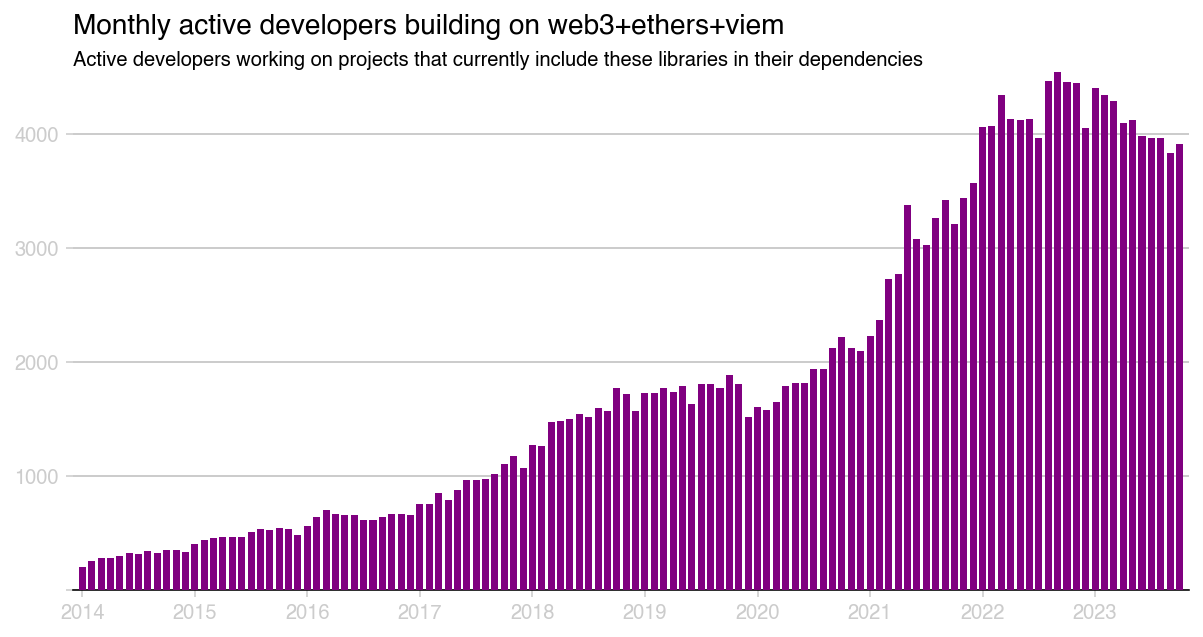

In [23]:
df = pd.DataFrame(mads_query[1:], columns=mads_query[0])

fig, ax = plt.subplots(figsize=(10,5), facecolor='white', dpi=144)
ax.bar(
    data=df,
    x='Month',
    height='Active Developers',
    color='purple',
    width=.75,
    zorder=3
)

months = sorted(df['Month'].unique())
num_months = len(months)
ax.set_xlim([-1,num_months])
ax.set_xticks([x for x in range(0,num_months,12)])
xticklabels = [x[:-3] for x in months[::12]]
ax.set_xlabel("")

ax.set_xticklabels(xticklabels, rotation=0, color=GRAY)
ax.set_yticks([0,1000,2000,3000,4000])
ax.set_yticklabels(["","1000","2000","3000","4000"], color=GRAY)
ax.set_ylabel("")

ax.set_title(
    "Monthly active developers building on web3+ethers+viem", 
    fontweight="bold", 
    loc='left',
    fontsize=14
)    
ax.text(
    s="Active developers working on projects that currently include these libraries in their dependencies", 
    y=4600, 
    x=-1, 
    fontsize=10
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color=GRAY, linestyle='-', linewidth=1, axis='y', zorder=0)
ax.tick_params(which='both', color=GRAY)

# Active onchain users

In [56]:
active_users_query = execute_query(f"""
    WITH Users AS (
        SELECT 
            e."fromId" AS "user",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            COUNT(DISTINCT p."slug") AS "projects",
            SUM(e."amount") as "txns"
        FROM event e
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 25 -- TXN EVENTS ONLY
            AND p.slug IN ('{slugs}')
        GROUP BY
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT
        month AS "Month",
        COUNT("user") AS "Users"
    FROM Users
    WHERE 
        projects >= 3
        AND txns >= 10
        GROUP BY month
""", col_names=True)

KeyboardInterrupt: 

In [72]:
df = pd.DataFrame(active_users_query[1:], columns=active_users_query[0])
df = df[df['Month'].between('2022-01', '2023-09')]

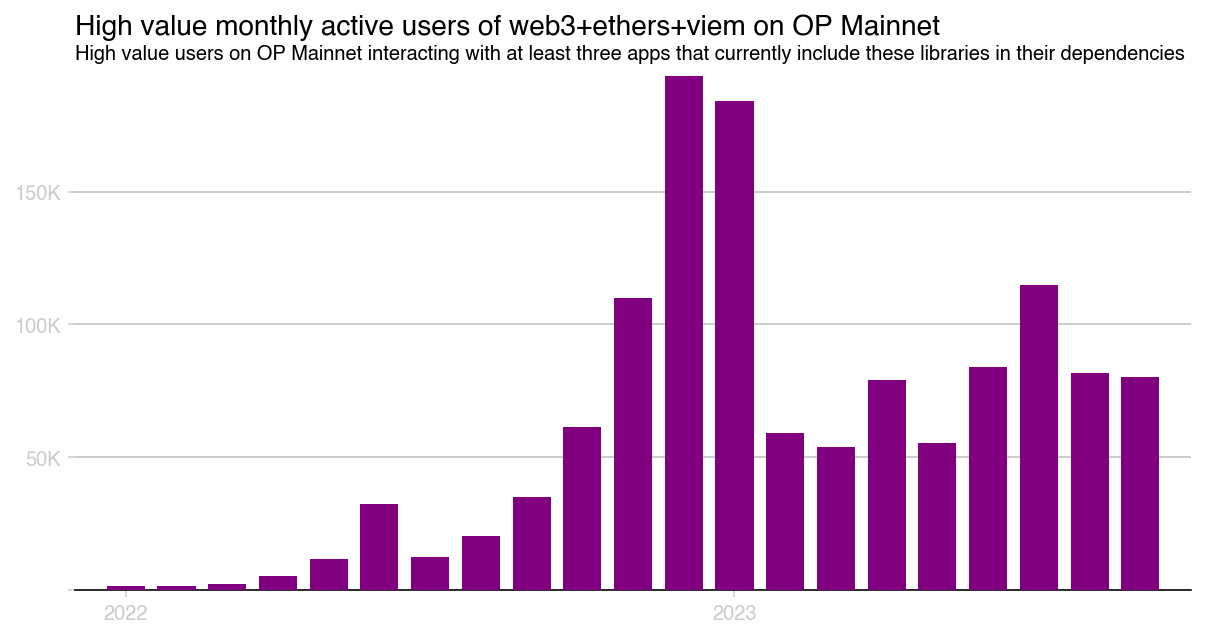

In [95]:
fig, ax = plt.subplots(figsize=(10,5), facecolor='white', dpi=144)
ax.bar(
    data=df,
    x='Month',
    height='Users',
    color='purple',
    width=.75,
    zorder=3
)

months = sorted(df['Month'].unique())
num_months = len(months)
ax.set_xlim([-1,num_months])
ax.set_xticks([x for x in range(0,num_months,12)])
xticklabels = [x[:-3] for x in months[::12]]
ax.set_xlabel("")
ax.set_xticklabels(xticklabels, rotation=0, color=GRAY)

ax.set_ylim(0,205000)
ax.set_yticks([0,50000,100000,150000])
ax.set_yticklabels(["","50K","100K","150K"], color=GRAY)
ax.set_ylabel("")

ax.set_title(
    "High value monthly active users of web3+ethers+viem on OP Mainnet", 
    fontweight="bold", 
    loc='left',
    fontsize=14
)    
ax.text(
    s="High value users on OP Mainnet interacting with at least three apps that currently include these libraries in their dependencies",
    y=200000, 
    x=-1, 
    fontsize=10
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color=GRAY, linestyle='-', linewidth=1, axis='y', zorder=0)
ax.tick_params(which='both', color=GRAY)

In [96]:
fees_query = execute_query(f"""
    SELECT 
        p."slug" AS "slug",
        SUM(e."amount") as "fees"
    FROM event e
    JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
    JOIN project p ON paa."projectId" = p.id         
    WHERE 
        e."typeId" = 26 -- L2 FEES
        AND p."slug" IN ('{slugs}')
        AND e."time" >= '2023-04-01'
    GROUP BY p."slug"
""", col_names=False)
fees = {x[0]:x[1] for x in fees_query}

In [105]:
names_query = execute_query(f"""SELECT slug, name FROM project WHERE slug IN ('{slugs}')""", col_names=False)
names_mapping = {slug: name for (slug, name) in names_query}

In [116]:
fees_data = []

for (dependency, dependent) in deps:
    fees_data.append({
        'Dependency': f"{names_mapping.get(dependency)}",
        'Dependent': names_mapping.get(dependent),
        'Fees': fees.get(dependent, 0)
    }) 
    
df_fees = pd.DataFrame(fees_data)
fees_counter = df_fees.groupby('Dependent')['Fees'].count()   
df_fees['Fees'] = df_fees.apply(lambda x: x['Fees'] / 1e18 / fees_counter.get(x['Dependent']), axis=1)
df_fees['Fees'].sum()

777.4564103215139

In [117]:
fig_data = make_sankey_graph(
    df_fees, 
    cat_cols=['Dependency', 'Dependent'], 
    value_col='Fees', 
    title="", 
    height=1000, 
    width=1000
)
fig = go.Figure(fig_data)
fig